In [1]:
import concurrent.futures
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ARK's daily trades
TRADES_DATE = "2021-02-01"
DELTA = 1

year, month, day = TRADES_DATE.split("-")
files = list(Path(f"./trades/").glob(f"ARK_Trade_{''.join([month, day, year])}_*.csv"))
if len(files)>1:
    raise ValueError("more than 1 file for the given date")
    
trades = pd.read_csv(
    files[0],
    header=3,
    usecols=["FUND", "Date", "Direction", "Ticker", "CUSIP", "Name", "Shares", "% of ETF"]
)
trades.columns = trades.columns.map(lambda x:x.lower())
trades.sort_values("ticker", inplace=True)
print(trades.shape)
trades.head(10)

(31, 8)


,fund,date,direction,ticker,cusip,name,shares,% of etf
22,ARKW,2021-02-01,Sell,API,00851L103,AGORA INC,54100.0,0.0577
25,ARKQ,2021-02-01,Sell,AVAV,8073108,AEROVIRONMENT INC,6132.0,0.0241
24,ARKK,2021-02-01,Buy,BEAM,07373V105,BEAM THERAPEUTICS INC,58218.0,0.0241
14,ARKW,2021-02-01,Buy,BEKE,482497104,KE HOLDINGS INC,110900.0,0.0986
18,ARKQ,2021-02-01,Sell,BYDDY,05606L100,BYD CO LTD,31503.0,0.0671
27,ARKG,2021-02-01,Buy,CDXS,192005106,CODEXIS INC,62497.0,0.0134
2,ARKW,2021-02-01,Buy,DKNG,26142R104,DRAFTKINGS INC,620300.0,0.5007
21,ARKK,2021-02-01,Buy,FATE,31189P102,FATE THERAPEUTICS INC,154509.0,0.0608
12,ARKQ,2021-02-01,Sell,FLIR,302445101,FLIR SYSTEMS INC,70604.0,0.1255
5,ARKW,2021-02-01,Sell,FSLY,31188V100,FASTLY INC,166618.0,0.2675


In [3]:
# open prices of traded stocks
open_configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Open"} for ticker in trades["ticker"].unique()] # on ark's trade date

def parallel_fetch_daily_data(config):
    try:
        # fetch daily market data from yahoo finance
        df = web.get_data_yahoo(config["ticker"], start=config["date"], end=config["date"])[[config["on"]]]
        df["ticker"] = config["ticker"]
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)


open_prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    open_prices.extend(executor.map(parallel_fetch_daily_data, open_configs))
open_prices = pd.concat(open_prices)
open_prices.reset_index(inplace=True)
open_prices.set_index("ticker", inplace=True)
print(open_prices.shape)
open_prices.head()

object of type 'float' has no len()
(27, 2)


,Date,Open
ticker,,
API,2021-02-01,72.080002
AVAV,2021-02-01,120.040001
BEAM,2021-02-01,99.709999
BEKE,2021-02-01,61.520000
BYDDY,2021-02-01,64.339996


In [4]:
# net & volume of trades (assume on open price)
net = trades.copy()[["ticker", "shares", "direction"]]
net["shares"] = net.apply(lambda row:row["shares"] if row["direction"]=="Buy" else -row["shares"], axis=1)
net = net.groupby("ticker").sum()

net = net.join(open_prices, how="inner") # link to price

net["signal"] = net["shares"].apply(lambda x: "Buy" if x>0 else "Sell")
net["volume"] = net["shares"] * net["Open"]
net["abs_volume"] = abs(net["volume"])

net.sort_values("abs_volume", ascending=False, inplace=True)
print(net.shape)
net.head()

(27, 6)


,shares,Date,Open,signal,volume,abs_volume
ticker,,,,,,
NVDA,92654.0,2021-02-01,522.130005,Buy,4.837743e+07,4.837743e+07
TSM,-349433.0,2021-02-01,124.540001,Sell,-4.351839e+07,4.351839e+07
TER,295371.0,2021-02-01,116.500000,Buy,3.441072e+07,3.441072e+07
DKNG,620300.0,2021-02-01,54.540001,Buy,3.383116e+07,3.383116e+07
ROKU,-73244.0,2021-02-01,395.329987,Sell,-2.895555e+07,2.895555e+07


In [5]:
FUTURE_DATE = datetime.strptime(TRADES_DATE, '%Y-%m-%d') + timedelta(days=DELTA)

# on ark's trades date
configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()]
# future date
configs.extend([{"ticker":ticker, "date":FUTURE_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()])

prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
print(prices.shape)
prices.tail(3)

object of type 'float' has no len()
object of type 'float' has no len()
(54, 2)


,Adj Close,ticker
Date,,
2021-02-02,121.610001,TER
2021-02-02,128.440002,TSM
2021-02-02,144.860001,Z


In [6]:
returns = [] # actual price changes
gg = prices.groupby("ticker")
for g in gg.groups:
    gdf = gg.get_group(g)
    if len(gdf)>2:
        raise ValueError("records exceed 2. can only compare 2 records")
    ticker_return = gdf["Adj Close"].pct_change().loc[FUTURE_DATE]
    returns.append({
        "ticker":g,
        "return":ticker_return,
        "actual":"Buy" if ticker_return > 0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns.set_index("ticker", inplace=True)
returns.head(3)

,return,actual
ticker,,
API,0.017255,Buy
AVAV,0.000422,Buy
BEAM,0.006609,Buy


In [7]:
df = net.join(returns).sort_values("abs_volume", ascending=False)
df.head(50)

,shares,Date,Open,signal,volume,abs_volume,return,actual
ticker,,,,,,,,
NVDA,92654.0,2021-02-01,522.130005,Buy,4.837743e+07,4.837743e+07,0.024156,Buy
TSM,-349433.0,2021-02-01,124.540001,Sell,-4.351839e+07,4.351839e+07,0.014053,Buy
TER,295371.0,2021-02-01,116.500000,Buy,3.441072e+07,3.441072e+07,0.034538,Buy
DKNG,620300.0,2021-02-01,54.540001,Buy,3.383116e+07,3.383116e+07,0.085469,Buy
ROKU,-73244.0,2021-02-01,395.329987,Sell,-2.895555e+07,2.895555e+07,0.006127,Buy
PCAR,263029.0,2021-02-01,91.800003,Buy,2.414606e+07,2.414606e+07,0.007787,Buy
SQ,-88752.0,2021-02-01,215.809998,Sell,-1.915357e+07,1.915357e+07,0.025638,Buy
FSLY,-166618.0,2021-02-01,109.879997,Sell,-1.830799e+07,1.830799e+07,-0.030729,Sell
PYPL,-74931.0,2021-02-01,238.369995,Sell,-1.786130e+07,1.786130e+07,0.029977,Buy


<Figure size 720x504 with 0 Axes>

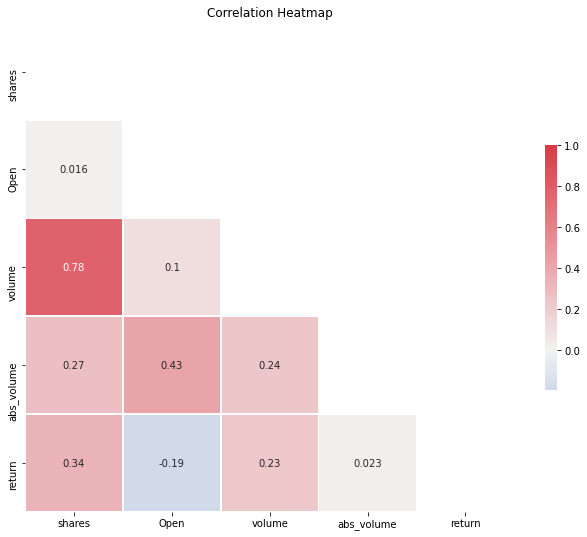

In [8]:
# correlation heatmap
plt.figure(figsize=(10,7))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Correlation Heatmap");

              precision    recall  f1-score   support

         Buy       1.00      0.43      0.61        23
        Sell       0.24      1.00      0.38         4

    accuracy                           0.52        27
   macro avg       0.62      0.72      0.49        27
weighted avg       0.89      0.52      0.57        27



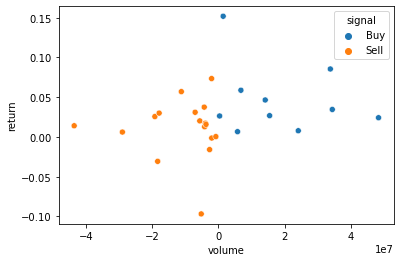

In [9]:
print(classification_report(df["actual"], df["signal"]))
sns.scatterplot(x=df["volume"], y=df["return"], hue=df["signal"])

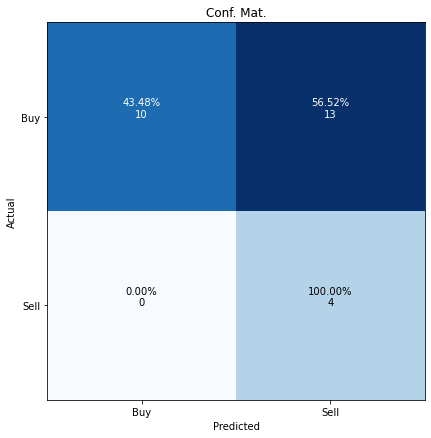

In [10]:
def plot_confusion_matrix_(cm, target_names, title='Conf. Mat.', normalize=True, saveit=False, showit=True):
    import itertools
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     thresh = cm_norm.max() / 1.5 if normalize else cm.max() / 2
    thresh =  cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, 
                     "{:0.2f}%\n{:,}".format(100*cm_norm[i, j], cm[i, j]),
                     horizontalalignment="center",
                     # color="white" if cm_norm[i, j] > thresh else "black",
                     color="white" if cm[i, j] > thresh else "black",
                    )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if saveit:
        plt.savefig(fname=saveit)
    if showit:
        plt.show()
plot_confusion_matrix_(confusion_matrix(df["actual"], df["signal"]), ["Buy", "Sell"])